# Global/Universal Initializations

In [32]:
import random
import numpy
import numpy as np
import os
import imageio.v2 as imageio
from math import sqrt
from scipy.stats import norm
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

%matplotlib inline


numofmol = 8
N = 30
radius = 0.2
vradius=0.2
theta = 45

delta = 0.4
# Total time.
T = 7
# Time step size
dt = T/N

traj = np.zeros((2,N,numofmol))
initialrot = np.zeros((numofmol,2))
where = np.zeros((numofmol))

ratiointra = 0.5



In [33]:
# function is also used in the stick cross generation
def make_stick_line(theta,radius):

    y = np.linspace(-2,2,100)

    xlow = np.zeros((100,))
    xlow[:] = -radius
    xhigh = np.zeros((100,))
    xhigh[:] = radius

    line1 = np.c_[xlow,y]
    line2 = np.c_[xhigh,y]

    c, s = np.cos(theta), np.sin(theta)
    rot = np.array(((c, -s), (s, c)))

    line1rot = line1 @ rot
    line2rot = line2 @ rot
    

    return line1rot, line2rot
line1, line2 = make_stick_line(theta,radius)

# Vertical Stick

In [34]:
"""
brownian() implements one dimensional Brownian motion (i.e. the Wiener process).
"""


def brownian_singlestep(x0, n, dt, delta, radius, theta, out=None):
    """
    Generate an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.
    
    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an array (or array-like), each value in `x0` is treated as
    an initial condition, and the value returned is a numpy array with one
    more dimension than `x0`.

    Arguments
    ---------
    x0 : float or numpy array (or something that can be converted to a numpy array
         using numpy.asarray(x0)).
        The initial condition(s) (i.e. position(s)) of the Brownian motion.
    n : int
        The number of steps to take.
    dt : float
        The time step.
    delta : float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.
    out : numpy array or None
        If `out` is not None, it specifies the array in which to put the
        result.  If `out` is None, a new numpy array is created and returned.
    sticks : int
        The number of sticks (pairs of wall) in the simulation.
        Used for conditionals as more collisions will need to be checked.

    Returns
    -------
    A numpy array of floats with shape `x0.shape + (n,)`.
    
    Note that the initial value `x0` is not included in the returned array.
    """

    x0 = np.asarray(x0)
    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    coordhold = np.copy(x0)
    coordfinal = np.zeros((2,n))
    #coordfinal = []

    c, s = np.cos(theta), np.sin(theta)
    rot = np.array(((c, -s), (s, c)))

    if x0[0] < -radius:
        where=0
        for i in range(n):
            if i == 0:
                coordfinal[:,0] = x0
            #print(i)
            else:
                r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                if (r[0] + coordhold[0]) < -radius:
                    coordhold += r
                    coordfinal[:,i] = coordhold
                else:
                    while (r[0] + coordhold[0]) > -radius:
                        r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                    coordhold += r
                    coordfinal[:,i] = coordhold
    elif x0[0] > radius:
        where=0
        for i in range(n):
            if i == 0:
                coordfinal[:,0] = x0
            #print(i)
            else:
                r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                if (r[0] + coordhold[0]) > radius:
                    coordhold += r
                    coordfinal[:,i] = coordhold
                else:
                    while (r[0] + coordhold[0]) < radius:
                        r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                    coordhold += r
                    coordfinal[:,i] = coordhold
    else:
        where = 1
        for i in range(n):
            if i == 0:
                coordfinal[:,0] = x0
            #print(i)
            else:
                r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                if (r[0] + coordhold[0]) > -radius and (r[0] + coordhold[0]) < radius:
                    coordhold += r
                    coordfinal[:,i] = coordhold
                else:
                    while (r[0] + coordhold[0]) < -radius or (r[0] + coordhold[0]) > radius:
                        r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                    coordhold += r
                    coordfinal[:,i] = coordhold

    coordfinal = np.squeeze(np.array(coordfinal)) 
    # Add the initial condition.
    #coordfinal += np.expand_dims(x0, axis=-1)
    coordfinal = np.transpose(rot) @ coordfinal
    initialrot = np.transpose(rot) @ x0
    
    return coordfinal,where,initialrot

In [35]:
initialinx = numpy.random.uniform(low=-radius, high=radius, size=(round(numofmol*ratiointra),1))
initialiny = numpy.random.uniform(low=-1.5, high=1.5, size=(round(numofmol*ratiointra),1))
initialincomb = np.concatenate((initialinx,initialiny),axis=1)

initialleftx = numpy.random.uniform(low=-1.5, high=-radius, size=(round(numofmol*(1-ratiointra)*0.5),1))
initiallefty = numpy.random.uniform(low=-1.5, high=1.5, size=(round(numofmol*(1-ratiointra)*0.5),1))
initialleftcomb = np.concatenate((initialleftx,initiallefty),axis=1)

initialrightx = numpy.random.uniform(low=radius, high=1.5, size=(round(numofmol*(1-ratiointra)*0.5),1))
initialrighty = numpy.random.uniform(low=-1.5, high=1.5, size=(round(numofmol*(1-ratiointra)*0.5),1))
initialrightcomb = np.concatenate((initialrightx,initialrighty),axis=1)

initial = np.concatenate((initialincomb,initialleftcomb,initialrightcomb),axis=0)



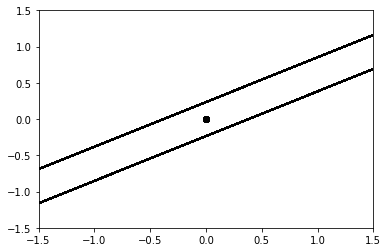

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
filenames = []

for i in range(N):
    print(i)
    for j in range(numofmol):

        new_y = traj[1,:i,j]
        new_x = traj[0,:i,j]

        if i == 0:
            ax.scatter(traj[0,0,j],traj[1,0,j],color='black')
        #elif i==N-1:
            #ax.scatter(traj[0,i,j],traj[1,i,j])
        if where[j] == 1:
            ax.plot(new_x,new_y,'deepskyblue')
        else:
            ax.plot(new_x,new_y,'lightskyblue')
        ax.plot(line1[:,0],line1[:,1],color='black')
        ax.plot(line2[:,0],line2[:,1],color='black')
        plt.xlim((-1.5, 1.5))   # set the xlim to left, right
        plt.ylim((-1.5, 1.5)) 


    plt.savefig(f'test_{i}.png')
    filenames.append(f'test_{i}.png')
    #ax.clear()
    #display(fig)
    clear_output(wait=True)

# Stick Cross

In [37]:
def brownian_singlestep_cross(x0, n, dt, delta, radius, vradius, theta, out=None):
    x0 = np.asarray(x0)
    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    coordhold = np.copy(x0)
    coordfinal = np.zeros((2,n))
    #coordfinal = []

    c, s = np.cos(theta), np.sin(theta)
    rot = np.array(((c, -s), (s, c)))
    # Quadrant 1 check
    if x0[0] >  radius and x0[1] > vradius: 
        where=0
        for i in range(n):
            print(i)
            print("Q1 For Loop")
            if i == 0:
                coordfinal[:,0] = x0
                print("Q1 If Statement")
            else:
                print("Q1 Else Statement")
                r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                if (r[0] + coordhold[0]) > radius and (r[1] + coordhold[1]) > vradius:
                    print("Q1 Else If Statement")
                    coordhold += r
                    coordfinal[:,i] = coordhold
                else:
                    print("Q1 Else Else Statement")
                    while (r[0] + coordhold[0]) < radius or (r[1] + coordhold[1]) < vradius:
                        print("Q1 Else Else While Statement")
                        r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                    coordhold += r
                    coordfinal[:,i] = coordhold
                    print("Q1 Else Else Post-While Statement")
    # Quadrant 2 check
    elif x0[0] < -radius and x0[1] > vradius:
        where = 0
        for i in range(n):
            print(i)
            print("Quadrant 2, Iteration:", i)
            if i == 0:
                coordfinal[:,0] = x0
            else:
                r = norm.rvs(size=(2,), scale=delta*sqrt(dt))
                if (r[0] + coordhold[0]) < -radius and (r[1] + coordhold[1]) > vradius:
                    coordhold += r
                    coordfinal[:,i] = coordhold
                else:
                    print("Entering Quadrant 2 While Loop")
                    while (r[0] + coordhold[0]) > -radius or (r[1] + coordhold[1]) < vradius:
                        r = norm.rvs(size=(2,), scale=delta*sqrt(dt))
                        print("Inside Quadrant 2 While Loop")
                    coordhold += r
                    coordfinal[:,i] = coordhold
    # Quadrant 3 check
    elif x0[0] < -radius and x0[1] < -vradius:
        where=0
        for i in range(n):
            print(i)
            print("Q3 For Loop")
            if i == 0:
                coordfinal[:,0] = x0
                print("Q3 If Statement")
            else:
                print("Q3 Else Statement")
                r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                if (r[0] + coordhold[0]) < -radius and (r[1] + coordhold[1]) < -vradius:
                    print("Q3 Else If Statement")
                    coordhold += r
                    coordfinal[:,i] = coordhold
                else:
                    print("Q3 Else Else Statement")
                    while (r[0] + coordhold[0]) > -radius or (r[1] + coordhold[1]) > -vradius:
                        print("Q3 Else Else While Statement")
                        r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                    coordhold += r
                    coordfinal[:,i] = coordhold
                    print("Q3 Else Else Post-While Statement")
    # Quadrant 4 check
    elif x0[0] > radius and x0[1] < -vradius:
        where=0
        for i in range(n):
            print("Q4 For Loop")
            print(i)
            if i == 0:
                coordfinal[:,0] = x0
                print("Q4 If Statement")
            else:
                print("Q4 Else Statement")
                r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                if (r[0] + coordhold[0]) > radius and (r[1] + coordhold[1]) < -vradius:
                    print("Q4 Else If Statement")
                    coordhold += r
                    coordfinal[:,i] = coordhold
                else:
                    print("Q4 Else Else Statement")
                    while (r[0] + coordhold[0]) < radius or (r[1] + coordhold[1]) > -vradius:
                        print("Q4 Else Else While Statement")
                        r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                    coordhold += r
                    coordfinal[:,i] = coordhold
                    print("Q4 Else Else Post-While Statement")

    # horizontal stick check
    # Does not need to check is x0 is above or below the stick as it is already checked in the quadrant checks
    elif x0[1] < vradius and x0[1] > -vradius: 
        where=1
        for i in range(n):
            print(i)
            print("Horizontal Stick For Loop")
            if i == 0:
                coordfinal[:,0] = x0
            else:
                r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                if (r[1] + coordhold[1]) < vradius and (r[1] + coordhold[1]) > -vradius:
                    coordhold += r
                    coordfinal[:,i] = coordhold
                else:
                    while (r[1] + coordhold[1]) > vradius or (r[1] + coordhold[1]) < -vradius:
                        r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                    coordhold += r
                    coordfinal[:,i] = coordhold
    # else case should be the vertical stick check
    elif x0[0] > -radius and x0[0] < radius:
        where=0
        where = 1
        for i in range(n):
            print(i)
            print("vertical stick case")
            if i == 0:
                print("vstick if")
                coordfinal[:,0] = x0
            else:
                r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                print("vstick else")
                if (r[0] + coordhold[0]) > -radius and (r[0] + coordhold[0]) < radius:
                    print("vstick else > if")
                    coordhold += r
                    coordfinal[:,i] = coordhold
                else:
                    print("vstick else > else")
                    while (r[0] + coordhold[0]) < -radius or (r[0] + coordhold[0]) > radius:
                        print("vstick else > else > while")
                        r = norm.rvs(size=(2,),scale=delta*sqrt(dt))
                    coordhold += r
                    coordfinal[:,i] = coordhold
    else:
        print("conditionals failed")
        print(x0)

    coordfinal = np.squeeze(np.array(coordfinal)) 
    # Add the initial condition.
    #coordfinal += np.expand_dims(x0, axis=-1)
    coordfinal = np.transpose(rot) @ coordfinal
    initialrot = np.transpose(rot) @ x0
    
    return coordfinal,where,initialrot

In [38]:
# What's probably more efficient is to have a counter of how many particles need to be in each area, and then reduce a counter as particles are placed in each area.
# Then, if the counter is 0, then the particles can't be placed in that area.
# Two Pairs (CROSS)
# In vertical stick, generate initial position/coordinate in top area only.
initialinx = numpy.random.uniform(low=-radius, high=radius, size=(round(numofmol*ratiointra*0.25)*2,1))
initialiny = numpy.random.uniform(low=vradius, high=1.5, size=(round(numofmol*ratiointra*0.25),1))
initialiny2= numpy.random.uniform(low=-1.5, high=-vradius, size=(round(numofmol*ratiointra*0.25),1))
initialiny = np.concatenate((initialiny,initialiny2),axis=0)
initialinVStick = np.concatenate((initialinx,initialiny),axis=1)

initialinx = numpy.random.uniform(low=-1.5,high=-radius,size=(round(numofmol*ratiointra*0.25),1))
initialinx2= numpy.random.uniform(low=radius,high=1.5,size=(round(numofmol*ratiointra*0.25),1))
initialinx = np.concatenate((initialinx,initialinx2),axis=0)
initialiny = numpy.random.uniform(low=-vradius,high=vradius,size=(round(numofmol*ratiointra*0.25)*2,1))
initialinHStick = np.concatenate((initialinx,initialiny),axis=1)

initialQ1x = numpy.random.uniform(low=radius,high=1.5,size=(round(numofmol*(1-ratiointra)*0.25),1))
initialQ1y = numpy.random.uniform(low=vradius,high=1.5,size=(round(numofmol*(1-ratiointra)*0.25),1))
initialQ1 = np.concatenate((initialQ1x,initialQ1y),axis=1)

initialQ2x = numpy.random.uniform(low=-1.5,high=-radius,size=(round(numofmol*(1-ratiointra)*0.25),1))
initialQ2y = numpy.random.uniform(low=vradius,high=1.5,size=(round(numofmol*(1-ratiointra)*0.25),1))
initialQ2 = np.concatenate((initialQ2x,initialQ2y),axis=1)

initialQ3x = numpy.random.uniform(low=-1.5,high=-radius,size=(round(numofmol*(1-ratiointra)*0.25),1))
initialQ3y = numpy.random.uniform(low=-1.5,high=-vradius,size=(round(numofmol*(1-ratiointra)*0.25),1))
initialQ3 = np.concatenate((initialQ3x,initialQ3y),axis=1)

initialQ4x = numpy.random.uniform(low=radius,high=1.5,size=(round(numofmol*(1-ratiointra)*0.25),1))
initialQ4y = numpy.random.uniform(low=-1.5,high=-vradius,size=(round(numofmol*(1-ratiointra)*0.25),1))
initialQ4 = np.concatenate((initialQ4x,initialQ4y),axis=1)

initialQcomb = np.concatenate((initialQ1,initialQ2,initialQ3,initialQ4),axis=0)

initial = np.concatenate((initialinVStick,initialinHStick,initialQcomb),axis=0)
print("finished generating")
# There appear to be no issues with the initial positions.

finished generating


In [39]:
where = np.zeros(numofmol) # initialize where to a default value
for i in range(numofmol):
    print("mol #",i)
    print(initial[i,:])
    [traj[:,:,i],where[i],initialrot[i,:]] = brownian_singlestep_cross(initial[i,:], N, dt, delta,radius,vradius,theta)

mol # 0
[0.18337839 0.60482748]
0
vertical stick case
vstick if
1
vertical stick case
vstick else
vstick else > else
vstick else > else > while
vstick else > else > while
vstick else > else > while
2
vertical stick case
vstick else
vstick else > if
3
vertical stick case
vstick else
vstick else > if
4
vertical stick case
vstick else
vstick else > if
5
vertical stick case
vstick else
vstick else > if
6
vertical stick case
vstick else
vstick else > else
vstick else > else > while
7
vertical stick case
vstick else
vstick else > if
8
vertical stick case
vstick else
vstick else > if
9
vertical stick case
vstick else
vstick else > else
vstick else > else > while
vstick else > else > while
vstick else > else > while
10
vertical stick case
vstick else
vstick else > else
vstick else > else > while
vstick else > else > while
11
vertical stick case
vstick else
vstick else > if
12
vertical stick case
vstick else
vstick else > if
13
vertical stick case
vstick else
vstick else > else
vstick else > el

In [40]:
def make_horiz_line(theta,vradius):
    
    x = np.linspace(-2,2,100)
    
    ylow = np.zeros((100,))
    yhigh = np.zeros((100,))
    ylow[:] = -vradius
    yhigh[:] = vradius
    
    line3=np.c_[x,ylow]
    line4=np.c_[x,yhigh]
    
    c, s = np.cos(theta), np.sin(theta)
    rot = np.array(((c, -s), (s, c)))
    
    line3rot = line3 @ rot
    line4rot = line4 @ rot
    
    return line3rot, line4rot
line3, line4 = make_horiz_line(theta,vradius)

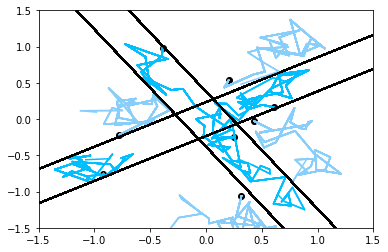

In [41]:
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
filenames = []

for i in range(N):
    print(i)
    for j in range(numofmol):

        new_y = traj[1,:i,j]
        new_x = traj[0,:i,j]

        if i == 0:
            ax.scatter(traj[0,0,j],traj[1,0,j],color='black')
        #elif i==N-1:
            #ax.scatter(traj[0,i,j],traj[1,i,j])
        if where[j] == 1:
            ax.plot(new_x,new_y,'deepskyblue')
        else:
            ax.plot(new_x,new_y,'lightskyblue')
        ax.plot(line1[:,0],line1[:,1],color='black')
        ax.plot(line2[:,0],line2[:,1],color='black')
        ax.plot(line3[:,0],line3[:,1],color='black')
        ax.plot(line4[:,0],line4[:,1],color='black')
        plt.xlim((-1.5, 1.5))   # set the xlim to left, right
        plt.ylim((-1.5, 1.5)) 


    plt.savefig(f'test_{i}.png')
    filenames.append(f'test_{i}.png')
    #ax.clear()
    #display(fig)
    clear_output(wait=True)

In [42]:

with imageio.get_writer(f'{numofmol}mol_{theta}deg.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        os.remove(filename)  # delete the file after appending its data

# Now plot all points from the origin (universal)

In [43]:
origtraj = np.zeros((N,2,numofmol))

for i in range(numofmol):
    origtraj[:,0,i] = traj[0,:,i] - initialrot[i,0]
    origtraj[:,1,i] = traj[1,:,i] - initialrot[i,1]

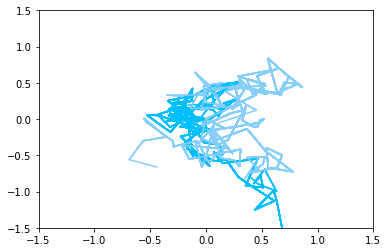

In [44]:
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
filenames = []

for i in range(N):
    print(i)
    for j in range(numofmol):

        new_y = origtraj[:i,1,j]
        new_x = origtraj[:i,0,j]


        #ax.plot(new_x,new_y,'b')
        if where[j] == 1:
            ax.plot(new_x,new_y,'deepskyblue')
        else:
            ax.plot(new_x,new_y,'lightskyblue')


        plt.xlim((-1.5, 1.5))   # set the xlim to left, right
        plt.ylim((-1.5, 1.5)) 


    plt.savefig(f'test_{i}.png')
    filenames.append(f'test_{i}.png')
    #ax.clear()
    #display(fig)
    clear_output(wait=True)

In [45]:
import imageio.v2 as imageio
with imageio.get_writer(f'{numofmol}mol_{theta}degstick_origin.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        os.remove(filename)

# Trying 3D

In [1]:
"""
brownian() implements one dimensional Brownian motion (i.e. the Wiener process).
"""

from math import sqrt
from scipy.stats import norm
import numpy as np


def brownian_singlestep(x0, n, dt, delta, radius, theta, out=None):
    """
    Generate an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.
    
    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an array (or array-like), each value in `x0` is treated as
    an initial condition, and the value returned is a numpy array with one
    more dimension than `x0`.

    Arguments
    ---------
    x0 : float or numpy array (or something that can be converted to a numpy array
         using numpy.asarray(x0)).
        The initial condition(s) (i.e. position(s)) of the Brownian motion.
    n : int
        The number of steps to take.
    dt : float
        The time step.
    delta : float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.
    out : numpy array or None
        If `out` is not None, it specifies the array in which to put the
        result.  If `out` is None, a new numpy array is created and returned.

    Returns
    -------
    A numpy array of floats with shape `x0.shape + (n,)`.
    
    Note that the initial value `x0` is not included in the returned array.
    """

    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    coordhold = np.copy(x0)
    coordfinal = np.zeros((3,n))
    #coordfinal = []

    #c, s = np.cos(theta), np.sin(theta)
    #rot = np.array(((c, -s), (s, c)))


    if x0[0] < -radius:
        print('less than -')
        for i in range(n):
            #print(i)
            r = norm.rvs(size=(3,),scale=delta*sqrt(dt))
            if (r[0] + coordhold[0]) < -radius:
                coordhold += r
                coordfinal[:,i] = coordhold
            else:
                while (r[0] + coordhold[0]) > -radius:
                    r = norm.rvs(size=(3,),scale=delta*sqrt(dt))
                coordhold += r
                coordfinal[:,i] = coordhold
    elif x0[0] > radius:
        print('greater than +')
        for i in range(n):
            #print(i)
            r = norm.rvs(size=(3,),scale=delta*sqrt(dt))
            if (r[0] + coordhold[0]) > radius:
                coordhold += r
                coordfinal[:,i] = coordhold
            else:
                while (r[0] + coordhold[0]) < radius:
                    r = norm.rvs(size=(3,),scale=delta*sqrt(dt))
                coordhold += r
                coordfinal[:,i] = coordhold
    else:
        print('inside')
        for i in range(n):
            #print(i)
            r = norm.rvs(size=(3,),scale=delta*sqrt(dt))
            if (r[0] + coordhold[0]) > -radius and (r[0] + coordhold[0]) < radius and (r[1] + coordhold[1]) > -radius and (r[1] + coordhold[1]) < radius:
                coordhold += r
                coordfinal[:,i] = coordhold
            else:
                while (r[0] + coordhold[0]) < -radius or (r[0] + coordhold[0]) > radius:
                    r = norm.rvs(size=(3,),scale=delta*sqrt(dt))
                coordhold += r
                coordfinal[:,i] = coordhold

    coordfinal = np.squeeze(np.array(coordfinal))

    # Add the initial condition.
    #coordfinal += np.expand_dims(x0, axis=-1)

    #coordfinal = rot @ coordfinal

    return coordfinal